In [41]:
# import necessary packages
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities, matutils

sns.set_style('ticks')

## Natural Language Processing Models
Now that the document-term matrices have been created, I will explore the data to ensure that the corpus is in a suitable format to run sentiment analysis.

In [7]:
# read in the cleaned data
timelines = pd.read_pickle('timelines_cleaned.pkl')
favorites = pd.read_pickle('favorites_cleaned.pkl')

In [8]:
# add a column to each dataframe to be able to identify where the tweet came from
timelines['type'] = 'timeline'
favorites['type'] = 'favorite'

In [9]:
# concatentate the dataframes of the timelines and favorites
full_df = pd.concat([timelines, favorites.drop(columns='favorited_by_id')])
print(full_df.shape)
full_df.head()

(1163063, 11)


,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text,type
0,1236035178331541505,Fri Mar 06 21:05:25 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,understanding power analysis in ab testing,timeline
1,1234619024736182272,Mon Mar 02 23:18:08 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,international talent segmentation for startups,timeline
2,1234276283745546240,Mon Mar 02 00:36:12 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,3,0,no thoughts head empty,timeline
3,1232902175753289728,Thu Feb 27 05:35:59 +0000 2020,baka_brooks,2649540547,1.232805e+18,lolegra,1.333492e+09,1,0,hi me,timeline
4,1232802180899332096,Wed Feb 26 22:58:38 +0000 2020,baka_brooks,2649540547,1.232699e+18,almeezyuh,1.006084e+08,0,0,bakabrooks,timeline


In [10]:
# instantiate word cloud
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

In [11]:
# Combine all of the tweets into a single string
all_tweets = [tweet for tweet in full_df.text]
all_tweets = ' '.join(all_tweets)

In [12]:
sample_tweets = full_df['text'].sample(500000)
sample_string = [tweet for tweet in sample_tweets]
sample_string = ' '.join(sample_string)

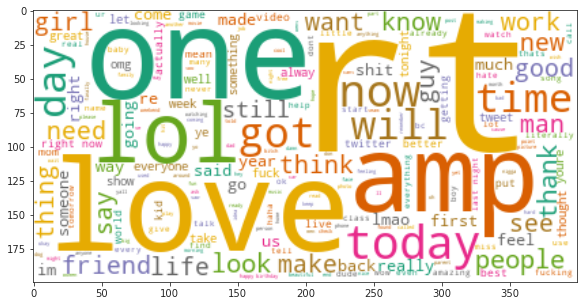

In [13]:
# generate word cloud from all tweets
cloud_tweets = wc.generate(sample_string)

plt.figure(figsize=(10,5))
plt.imshow(cloud_tweets, interpolation='bilinear');

Dope! No words really stick out as outliers here. It looks like the major words are all relevant to the Samsung event and/or features of the phone which is exactly what I want.

## Sentiment Analysis
My main objective is to accurately assign sentiment scores to the tweets and determine which features/aspects of the phone corresponded to each emotion. 

In [14]:
sentiment_df = full_df.copy()

In [15]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

sentiment_df['textblob_polarity'] = sentiment_df['text'].apply(pol)
sentiment_df['textblob_subjectivity'] = sentiment_df['text'].apply(sub)
sentiment_df.head()

,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text,type,textblob_polarity,textblob_subjectivity
0,1236035178331541505,Fri Mar 06 21:05:25 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,understanding power analysis in ab testing,timeline,0.0,0.0
1,1234619024736182272,Mon Mar 02 23:18:08 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,international talent segmentation for startups,timeline,0.0,0.0
2,1234276283745546240,Mon Mar 02 00:36:12 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,3,0,no thoughts head empty,timeline,-0.1,0.5
3,1232902175753289728,Thu Feb 27 05:35:59 +0000 2020,baka_brooks,2649540547,1.232805e+18,lolegra,1.333492e+09,1,0,hi me,timeline,0.0,0.0
4,1232802180899332096,Wed Feb 26 22:58:38 +0000 2020,baka_brooks,2649540547,1.232699e+18,almeezyuh,1.006084e+08,0,0,bakabrooks,timeline,0.0,0.0


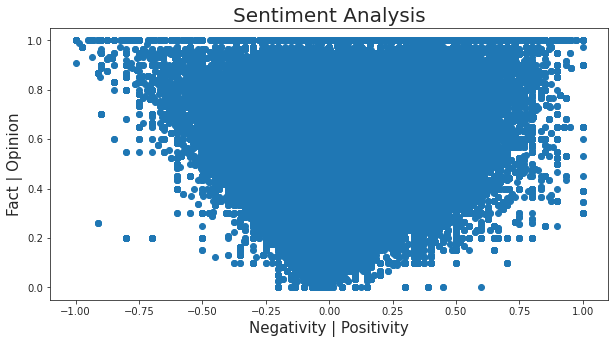

In [16]:
plt.figure(figsize=(10,5))

x = sentiment_df.textblob_polarity
y = sentiment_df.textblob_subjectivity
plt.scatter(x, y)
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('Negativity | Positivity', fontsize=15)
plt.ylabel('Fact | Opinion', fontsize=15);

### VADER Sentiment Analysis (Compound Scores)

In [17]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
analyzer = SentimentIntensityAnalyzer()
scores = []
for doc in sentiment_df['text']:
    vs = analyzer.polarity_scores(doc)
    scores.append(vs)

In [19]:
scores[:2]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.4215}]

In [20]:
negative_scores = [score['neg'] for score in scores]
positive_scores = [score['pos'] for score in scores]
neutral_scores = [score['neu'] for score in scores]
compound_scores = [score['compound'] for score in scores]

In [21]:
sentiment_df['vader_neg'] = negative_scores
sentiment_df['vader_pos'] = positive_scores
sentiment_df['vader_neu'] = neutral_scores
sentiment_df['vader_compound'] = compound_scores
sentiment_df.head()

,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text,type,textblob_polarity,textblob_subjectivity,vader_neg,vader_pos,vader_neu,vader_compound
0,1236035178331541505,Fri Mar 06 21:05:25 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,understanding power analysis in ab testing,timeline,0.0,0.0,0.000,0.000,1.000,0.0000
1,1234619024736182272,Mon Mar 02 23:18:08 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,0,0,international talent segmentation for startups,timeline,0.0,0.0,0.000,0.412,0.588,0.4215
2,1234276283745546240,Mon Mar 02 00:36:12 +0000 2020,baka_brooks,2649540547,NaN,None,NaN,3,0,no thoughts head empty,timeline,-0.1,0.5,0.667,0.000,0.333,-0.4588
3,1232902175753289728,Thu Feb 27 05:35:59 +0000 2020,baka_brooks,2649540547,1.232805e+18,lolegra,1.333492e+09,1,0,hi me,timeline,0.0,0.0,0.000,0.000,1.000,0.0000
4,1232802180899332096,Wed Feb 26 22:58:38 +0000 2020,baka_brooks,2649540547,1.232699e+18,almeezyuh,1.006084e+08,0,0,bakabrooks,timeline,0.0,0.0,0.000,0.000,1.000,0.0000


## Clustering
JUST USING FAVORITES FOR NOW, so I can run something

In [32]:
# create the corpus from the cleaned text using the user favorites
mask = sentiment_df['type'] == 'favorite'
corpus = list(sentiment_df.loc[mask].text)

In [30]:
# create a CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(corpus)

In [31]:
# create a dataframe from the document-term matrix
labels = [tweet[:30]+'...' for tweet in corpus]
dtm_count = pd.DataFrame(doc_word_count.toarray(), index=labels, columns=doc_word_count.get_feature_names())
print(dtm_count.shape)
dtm_count.head()

AttributeError: 'CountVectorizer' object has no attribute 'toarray'

In [ ]:
cls = MiniBatchKMeans(n_clusters=5, random_state=42)
cls.fit(np.array(dtm_count))

### PCA

In [ ]:
# reduce the features to 2D
pca = PCA(n_components=10, random_state=42)
reduced_features = pca.fit_transform(np.array(dtm_count))

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

In [ ]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(np.array(dtm_count)))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b');

## NMF
Non-negative matrix factorization will work better for tweets as it removes the "weights" factor (sigma) from single variable decomposiiton, deconstructing the documennt-term matrix to doc-topics and topics-terms.

In [33]:
# create a CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(corpus)

In [34]:
# instantiate nmf model
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [35]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [36]:
# display topics and words associated
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
just, got, want, did, said, say, wanna, girl, man, lol

Topic  1
like, feel, look, looks, really, shit, dont, don, girl, does

Topic  2
im, going, gonna, sorry, really, ive, hi, lol, dont, think

Topic  3
people, know, time, amp, new, day, don, good, today, got

Topic  4
love, happy, thank, life, birthday, guys, really, hope, beautiful, man


## LSA

In [37]:
# cv = CountVectorizer(stop_words=stop_words, ngram_range=(2,3), min_df = 10, max_df = 0.85)
cv = CountVectorizer(stop_words='english')
vectorized = cv.fit_transform(corpus)
n_topics = 5
lsa = TruncatedSVD(n_topics)
doc_topic = lsa.fit_transform(vectorized)
lsa.explained_variance_ratio_
topics = pd.DataFrame(lsa.components_.round(3),
             index = ["component_" + str(i) for i in range(0, n_topics)],
             columns = cv.get_feature_names())
topics
display_topics(lsa, cv.get_feature_names(), 10)


Topic  0
just, like, im, people, know, love, got, time, really, amp

Topic  1
like, feel, look, looks, people, dont, really, shit, feels, sounds

Topic  2
im, love, people, new, time, know, amp, day, good, today

Topic  3
people, love, amp, know, new, time, don, day, today, good

Topic  4
love, new, amp, day, today, got, happy, like, thank, year


## UMap

/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 227 separate connected components using meta-embedding (experimental)
  n_components
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation

FileNotFoundError: [Errno 2] No such file or directory: './images/plots/umap.png'

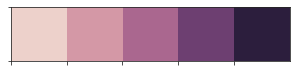

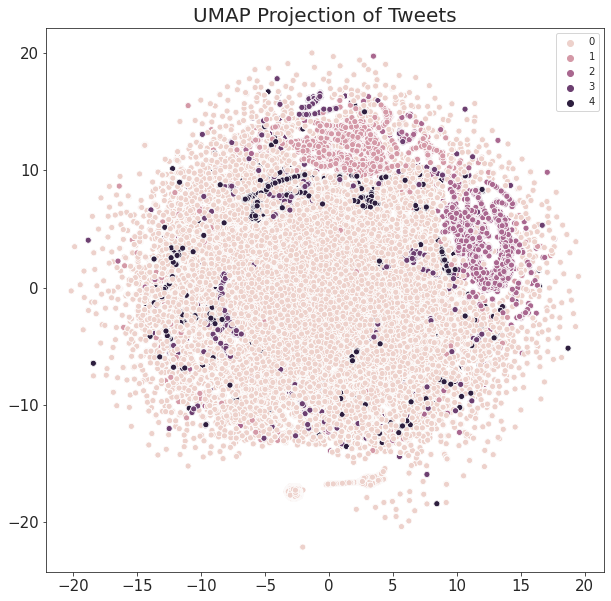

In [50]:
import umap.umap_ as umap

svd_model = TruncatedSVD(n_topics)
svd_model.fit(vectorized)

X_topics = svd_model.fit_transform(vectorized)

# Instantiate the clustering model
# clusters = KMeans(n_clusters=10)
# clusters.fit(X_topics)
# ypred = clusters.fit_predict(X_topics)
kmeans_labels = KMeans(n_clusters=5, n_jobs = -1).fit_predict(X_topics)

embedding = umap.UMAP(random_state=42).fit_transform(X_topics)

num_labels = len(set(kmeans_labels))

spectral = sns.palplot(sns.cubehelix_palette(num_labels))

plt.figure(figsize=(10,10))
sns.scatterplot(embedding[:, 0], embedding[:, 1], hue=kmeans_labels, cmap=spectral, legend='full')
plt.title('UMAP Projection of Tweets', fontsize=20)
plt.tick_params(labelsize=15)
plt.savefig('./images/plots/umap.png', transparent=True);

In [62]:
# add cluster labels to documents in sentiment_df
sentiment_df['cluster'] = np.nan
mask = sentiment_df['type'] == 'favorite'

sentiment_df[mask]['cluster'] = kmeans_labels

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<font color='red'>How to label just the "favorites" with clusters and leave the rest NaN?</font>

In [64]:
sentiment_df[mask]

,id,created_at,screen_name,user_id,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,favorite_count,retweet_count,text,type,textblob_polarity,textblob_subjectivity,vader_neg,vader_pos,vader_neu,vader_compound,cluster
0,1236533635290890240,Sun Mar 08 06:06:06 +0000 2020,AOC,138203134,1.236524e+18,nbcsnl,28221296.0,115728,3550,ok this is legendary,favorite,0.750000,0.750000,0.000,0.423,0.577,0.2960,NaN
1,1236523965759262720,Sun Mar 08 05:27:41 +0000 2020,nbcsnl,28221296,NaN,None,NaN,866736,169323,𝗙𝗹𝗶𝗽𝗽𝗲𝗱 𝘁𝗵𝗲 𝘀𝘄𝗶𝘁𝗰𝗵,favorite,0.000000,0.000000,0.000,0.000,1.000,0.0000,NaN
2,1236510979577524225,Sun Mar 08 04:36:05 +0000 2020,DojaCat,568545739,NaN,None,NaN,103837,6546,please try to be cool when you go to see peopl...,favorite,-0.075000,0.825000,0.096,0.220,0.683,0.4588,NaN
3,1236496908891435009,Sun Mar 08 03:40:10 +0000 2020,KenJee_DS,1159830350102781953,NaN,None,NaN,13,1,i just realized that yesterday broke view coun...,favorite,0.500000,0.500000,0.268,0.000,0.732,-0.6701,NaN
4,1236075484955410432,Fri Mar 06 23:45:35 +0000 2020,Kwammentary,1094750013304029187,1.236074e+18,jaboukie,319769408.0,101,0,,favorite,0.000000,0.000000,0.000,0.000,0.000,0.0000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547458,312416028254670848,Fri Mar 15 04:12:40 +0000 2013,quadswapshop,1260719647,3.124118e+17,Emilie1025,467585045.0,2,0,if you pee on it yell mineand it is,favorite,0.000000,0.000000,0.000,0.000,1.000,0.0000,NaN
547459,312158109944659968,Thu Mar 14 11:07:47 +0000 2013,quadswapshop,1260719647,NaN,None,NaN,3,0,pulled up to starbuckssaw barista in training ...,favorite,0.000000,0.000000,0.000,0.000,1.000,0.0000,NaN
547460,294566800736284672,Thu Jan 24 22:06:12 +0000 2013,MiK_KaY_KaY,111968118,NaN,None,NaN,1,0,someone please tell me what she has over meill...,favorite,0.000000,0.000000,0.000,0.204,0.796,0.3182,NaN
547461,283302659941871616,Mon Dec 24 20:06:32 +0000 2012,azizansari,6480682,NaN,None,NaN,2167,2746,there needs to be new yelp feature to help acc...,favorite,0.178788,0.362626,0.000,0.144,0.856,0.4019,NaN
